# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                       
Sample_084  C9JPD0;P58417;R4GMM9                                    16.836
Sample_197  Q14393;Q14393-2;Q14393-3;Q14393-4;Q14393-5              17.285
Sample_053  F5H5D3;Q9BQE3                                           13.316
Sample_002  A0A0U1RQV3;Q12805;Q12805-2;Q12805-3;Q12805-4;Q12805-5   20.662
Sample_129  P14618                                                  19.874
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups          
Sample_007  P01344;P01344-2;P01344-3   18.355
Sample_029  C9JKT8;Q9UEW3;Q9UEW3-2     16.539
Sample_157  I3L3R5                     13.737
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.794
            A0A075B6Q5                 12.116
            A0A075B6R2                 12.780
            A0A075B6S5                 12.567
            A0A087WSY4                 14.278
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.247
            Q9UI40;Q9UI40-2            12.257
            Q9UIW2                     12.765
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.561
            Q9UP79                     12.373
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.283,15.050,16.842,19.863,16.023,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.753,19.067,...,15.528,15.576,14.148,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.049,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.976,17.705,17.039,15.762,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.199,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.599,15.345,17.084,18.708,14.249,19.433,11.188,10.896
Sample_207,15.739,16.877,15.469,16.898,14.446,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.794,...,16.012,15.178,13.360,15.050,16.842,19.863,11.919,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.101,19.067,16.188,...,15.528,15.576,11.612,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.951,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.577,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.224,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.877,15.345,17.084,18.708,14.249,19.433,12.353,11.741
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 389.70it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.59it/s]

100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.12it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.08it/s]

100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.18it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.08it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.56it/s]

100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.08it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.01it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.88it/s]

100%|██████████| 6/6 [00:01<00:00,  2.83it/s]

100%|██████████| 6/6 [00:01<00:00,  3.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.54it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.52it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.11it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.09it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.26it/s]

100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.97it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.06it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.60it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.16it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.04it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.98it/s]

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.33it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.13it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.46it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.25it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.96it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.43it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.11it/s]

100%|██████████| 9/9 [00:03<00:00,  2.06it/s]

100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.65it/s]

 30%|███       | 3/10 [00:01<00:02,  2.49it/s]

 40%|████      | 4/10 [00:01<00:02,  2.16it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.25it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.37it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.46it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.46it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.69it/s]

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.27it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.43it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.17it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.99it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.94it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.98it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.14it/s]

100%|██████████| 11/11 [00:05<00:00,  2.29it/s]

100%|██████████| 11/11 [00:05<00:00,  2.16it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.99it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.89it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.68it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.33it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.15it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.02it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.93it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.62it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.44it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.32it/s]

100%|██████████| 12/12 [00:04<00:00,  2.18it/s]

100%|██████████| 12/12 [00:04<00:00,  2.77it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.48it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.97it/s]

 31%|███       | 4/13 [00:01<00:02,  3.64it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.24it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.83it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.64it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.79it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.75it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.91it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.10it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.21it/s]

100%|██████████| 13/13 [00:05<00:00,  2.36it/s]

100%|██████████| 13/13 [00:05<00:00,  2.21it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.51it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.66it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.17it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.05it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.95it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.09it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.22it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.21it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.38it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.42it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.43it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.49it/s]

100%|██████████| 14/14 [00:05<00:00,  2.71it/s]

100%|██████████| 14/14 [00:05<00:00,  2.42it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.54it/s]

 20%|██        | 3/15 [00:00<00:03,  3.40it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.87it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.54it/s]

 40%|████      | 6/15 [00:02<00:03,  2.50it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.08it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.89it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.76it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.80it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.07it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.29it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.37it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.52it/s]

100%|██████████| 15/15 [00:06<00:00,  2.63it/s]

100%|██████████| 15/15 [00:06<00:00,  2.36it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.063 0.025          0.849 0.244       0.147   
2             0.005 0.004      0.060 0.023          0.701 0.093       0.605   
3             0.004 0.003      0.054 0.015          0.719 0.086       0.666   
4             0.005 0.004      0.061 0.020          0.719 0.087       0.682   
5             0.004 0.003      0.058 0.020          0.720 0.094       0.696   
6             0.004 0.001      0.052 0.014          0.809 0.092       0.835   
7             0.006 0.008      0.059 0.019          0.810 0.087       0.840   
8             0.005 0.004      0.060 0.022          0.801 0.084       0.816   
9             0.004 0.002      0.051 0.014          0.809 0.078       0.831   
10            0.005 0.005      0.065 0.036          0.812 0.083       0.834   
11            0.007 0.006      0.080 0.030          0.838 0.077       0.830   
12            0.006 0.005      0.073 0.028          0.838 0.083       0.828   
13            0.005 0.005      0.055 0.018          0.835 0.081       0.823   
14            0.007 0.005      0.082 0.029          0.833 0.082       0.830   
15            0.007 0.006      0.072 0.037          0.831 0.082       0.828   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.243 0.120                  0.565 0.042        0.857   
2          0.106   0.644 0.081                  0.706 0.061        0.786   
3          0.107   0.685 0.075                  0.735 0.057        0.808   
4          0.114   0.692 0.076                  0.741 0.058        0.806   
5          0.108   0.702 0.079                  0.747 0.063        0.819   
6          0.106   0.816 0.071                  0.843 0.061        0.895   
7          0.104   0.819 0.066                  0.845 0.057        0.895   
8          0.103   0.803 0.065                  0.832 0.055        0.899   
9          0.100   0.816 0.069                  0.843 0.059        0.915   
10         0.100   0.819 0.069                  0.845 0.060        0.916   
11         0.100   0.830 0.069                  0.855 0.058        0.919   
12         0.103   0.828 0.070                  0.854 0.059        0.918   
13         0.099   0.825 0.069                  0.851 0.058        0.917   
14         0.102   0.827 0.071                  0.853 0.060        0.916   
15         0.102   0.825 0.070                  0.851 0.059        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.826 0.087        210.000 0.000  
2          0.066                  0.761 0.085        210.000 0.000  
3          0.064                  0.771 0.087        210.000 0.000  
4          0.063                  0.766 0.087        210.000 0.000  
5          0.062                  0.784 0.086        210.000 0.000  
6          0.054                  0.869 0.062        210.000 0.000  
7          0.053                  0.869 0.061        210.000 0.000  
8          0.052                  0.877 0.058        210.000 0.000  
9          0.048                  0.906 0.047        210.000 0.000  
10         0.049                  0.910 0.047        210.000 0.000  
11         0.049                  0.909 0.049        210.000 0.000  
12         0.050                  0.907 0.050        210.000 0.000  
13         0.050                  0.906 0.050        210.000 0.000  
14         0.049                  0.905 0.049        210.000 0.000  
15         0.049                  0.904 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 130.62it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.87it/s]

100%|██████████| 3/3 [00:00<00:00,  3.68it/s]

100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.31it/s]

100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.78it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.55it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.39it/s]

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

100%|██████████| 5/5 [00:02<00:00,  2.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.36it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.42it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.19it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.21it/s]

100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.27it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.59it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.02it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.50it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.37it/s]

100%|██████████| 7/7 [00:02<00:00,  2.13it/s]

100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.98it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.67it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.29it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.17it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.17it/s]

100%|██████████| 8/8 [00:03<00:00,  2.29it/s]

100%|██████████| 8/8 [00:03<00:00,  2.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.13it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.33it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.90it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.51it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.47it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.46it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.52it/s]

100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.33it/s]

 30%|███       | 3/10 [00:00<00:02,  3.29it/s]

 40%|████      | 4/10 [00:01<00:02,  2.59it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.39it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.28it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.26it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.31it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.33it/s]

100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.31it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.13it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.87it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.75it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.63it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.54it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.13it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.97it/s]

100%|██████████| 11/11 [00:04<00:00,  2.00it/s]

100%|██████████| 11/11 [00:04<00:00,  2.42it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  3.08it/s]

 25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

 33%|███▎      | 4/12 [00:01<00:04,  1.96it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.91it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.06it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.13it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.06it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.16it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.28it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.42it/s]

100%|██████████| 12/12 [00:05<00:00,  2.52it/s]

100%|██████████| 12/12 [00:05<00:00,  2.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.00it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.25it/s]

 31%|███       | 4/13 [00:01<00:03,  2.80it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.12it/s]

 46%|████▌     | 6/13 [00:02<00:04,  1.68it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.68it/s]

 62%|██████▏   | 8/13 [00:04<00:03,  1.65it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.87it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.01it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.18it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.26it/s]

100%|██████████| 13/13 [00:06<00:00,  2.24it/s]

100%|██████████| 13/13 [00:06<00:00,  2.14it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.80it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.24it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.22it/s]

 36%|███▌      | 5/14 [00:01<00:04,  2.25it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.33it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.38it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.36it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.40it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.44it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.56it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.65it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.15it/s]

100%|██████████| 14/14 [00:05<00:00,  2.03it/s]

100%|██████████| 14/14 [00:05<00:00,  2.36it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.56it/s]

 20%|██        | 3/15 [00:00<00:04,  2.90it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.68it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.51it/s]

 40%|████      | 6/15 [00:02<00:04,  1.94it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.73it/s]

 53%|█████▎    | 8/15 [00:03<00:04,  1.74it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.81it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.95it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.02it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.16it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.25it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.22it/s]

100%|██████████| 15/15 [00:07<00:00,  2.13it/s]

100%|██████████| 15/15 [00:07<00:00,  2.13it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.077 0.028          0.167 0.331       0.020   
2             0.007 0.005      0.097 0.033          0.634 0.181       0.326   
3             0.008 0.009      0.086 0.042          0.733 0.071       0.689   
4             0.007 0.006      0.076 0.033          0.730 0.078       0.673   
5             0.005 0.004      0.081 0.034          0.730 0.083       0.665   
6             0.006 0.006      0.085 0.039          0.730 0.082       0.656   
7             0.006 0.005      0.084 0.031          0.722 0.086       0.659   
8             0.005 0.004      0.074 0.034          0.759 0.090       0.756   
9             0.006 0.005      0.072 0.033          0.769 0.090       0.763   
10            0.005 0.004      0.064 0.027          0.801 0.079       0.805   
11            0.005 0.003      0.057 0.017          0.784 0.089       0.793   
12            0.007 0.007      0.085 0.035          0.794 0.080       0.790   
13            0.008 0.006      0.074 0.026          0.791 0.082       0.789   
14            0.007 0.006      0.080 0.032          0.802 0.080       0.796   
15            0.005 0.002      0.049 0.010          0.800 0.085       0.787   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.044   0.034 0.073                  0.505 0.019        0.870   
2          0.115   0.417 0.111                  0.585 0.070        0.684   
3          0.103   0.705 0.068                  0.752 0.052        0.876   
4          0.109   0.695 0.076                  0.745 0.058        0.872   
5          0.111   0.690 0.077                  0.742 0.059        0.871   
6          0.112   0.685 0.078                  0.738 0.059        0.870   
7          0.095   0.684 0.071                  0.735 0.056        0.872   
8          0.108   0.752 0.076                  0.788 0.063        0.890   
9          0.099   0.761 0.072                  0.796 0.061        0.893   
10         0.096   0.798 0.063                  0.828 0.053        0.911   
11         0.105   0.784 0.073                  0.815 0.062        0.917   
12         0.103   0.787 0.068                  0.819 0.056        0.918   
13         0.102   0.785 0.067                  0.817 0.057        0.916   
14         0.103   0.794 0.067                  0.824 0.056        0.916   
15         0.100   0.788 0.067                  0.819 0.057        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.834 0.086        210.000 0.000  
2          0.081                  0.610 0.095        210.000 0.000  
3          0.037                  0.836 0.051        210.000 0.000  
4          0.039                  0.829 0.054        210.000 0.000  
5          0.041                  0.829 0.059        210.000 0.000  
6          0.042                  0.827 0.058        210.000 0.000  
7          0.044                  0.834 0.059        210.000 0.000  
8          0.045                  0.864 0.058        210.000 0.000  
9          0.045                  0.865 0.058        210.000 0.000  
10         0.041                  0.886 0.054        210.000 0.000  
11         0.040                  0.899 0.048        210.000 0.000  
12         0.038                  0.899 0.047        210.000 0.000  
13         0.039                  0.897 0.048        210.000 0.000  
14         0.040                  0.895 0.050        210.000 0.000  
15         0.041                  0.893 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 922.43it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 27.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 14.94it/s]

100%|██████████| 3/3 [00:00<00:00, 14.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.16it/s]

100%|██████████| 4/4 [00:00<00:00, 14.87it/s]

100%|██████████| 4/4 [00:00<00:00, 15.06it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 19.57it/s]

 80%|████████  | 4/5 [00:00<00:00, 11.94it/s]

100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.25it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.30it/s]

100%|██████████| 6/6 [00:00<00:00, 13.70it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.71it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.60it/s]

100%|██████████| 7/7 [00:00<00:00, 12.36it/s]

100%|██████████| 7/7 [00:00<00:00, 13.09it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.41it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 12.67it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.84it/s]

100%|██████████| 8/8 [00:00<00:00, 13.71it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.83it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.31it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.75it/s]

100%|██████████| 9/9 [00:00<00:00, 11.79it/s]

100%|██████████| 9/9 [00:00<00:00, 12.51it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.15it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.56it/s]

 80%|████████  | 8/10 [00:00<00:00, 11.21it/s]

100%|██████████| 10/10 [00:00<00:00,  9.89it/s]

100%|██████████| 10/10 [00:00<00:00, 10.71it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.66it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 12.91it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 12.21it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.40it/s]

100%|██████████| 11/11 [00:00<00:00, 12.92it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.93it/s]

 42%|████▏     | 5/12 [00:00<00:00, 12.53it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 10.22it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 10.65it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.12it/s]

100%|██████████| 12/12 [00:01<00:00, 11.07it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.04it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.97it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.01it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.70it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.28it/s]

100%|██████████| 13/13 [00:01<00:00, 10.54it/s]

100%|██████████| 13/13 [00:01<00:00, 11.46it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 14.20it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.15it/s]

 50%|█████     | 7/14 [00:00<00:00, 10.78it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.37it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.99it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.80it/s]

100%|██████████| 14/14 [00:01<00:00, 10.60it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.64it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.33it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.86it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.92it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.28it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 11.63it/s]

100%|██████████| 15/15 [00:01<00:00, 12.10it/s]

100%|██████████| 15/15 [00:01<00:00, 12.52it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.073 0.029          0.000 0.000       0.000   
2             0.004 0.002      0.052 0.014          0.626 0.112       0.435   
3             0.008 0.008      0.085 0.037          0.630 0.117       0.435   
4             0.005 0.003      0.065 0.027          0.595 0.107       0.458   
5             0.006 0.006      0.083 0.034          0.638 0.096       0.577   
6             0.004 0.002      0.054 0.017          0.638 0.091       0.574   
7             0.006 0.007      0.063 0.026          0.658 0.088       0.564   
8             0.004 0.002      0.050 0.012          0.643 0.091       0.564   
9             0.005 0.003      0.063 0.024          0.643 0.101       0.565   
10            0.004 0.002      0.053 0.012          0.694 0.086       0.647   
11            0.004 0.000      0.055 0.015          0.702 0.081       0.671   
12            0.005 0.003      0.054 0.014          0.713 0.089       0.675   
13            0.004 0.002      0.055 0.016          0.716 0.085       0.687   
14            0.005 0.003      0.061 0.019          0.708 0.077       0.679   
15            0.005 0.004      0.065 0.025          0.718 0.084       0.683   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.749   
2          0.085   0.509 0.083                  0.620 0.056        0.693   
3          0.093   0.509 0.091                  0.622 0.060        0.684   
4          0.105   0.509 0.088                  0.611 0.059        0.682   
5          0.120   0.601 0.095                  0.668 0.076        0.773   
6          0.111   0.599 0.088                  0.667 0.070        0.770   
7          0.112   0.602 0.089                  0.675 0.067        0.769   
8          0.115   0.596 0.092                  0.667 0.069        0.770   
9          0.110   0.596 0.092                  0.667 0.072        0.771   
10         0.115   0.663 0.081                  0.718 0.062        0.812   
11         0.121   0.680 0.086                  0.731 0.066        0.821   
12         0.125   0.688 0.092                  0.738 0.071        0.819   
13         0.115   0.696 0.082                  0.743 0.065        0.818   
14         0.115   0.687 0.082                  0.736 0.062        0.814   
15         0.117   0.694 0.087                  0.742 0.067        0.815   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.690 0.082        210.000 0.000  
2          0.074                  0.635 0.087        210.000 0.000  
3          0.074                  0.628 0.089        210.000 0.000  
4          0.070                  0.620 0.088        210.000 0.000  
5          0.067                  0.716 0.069        210.000 0.000  
6          0.065                  0.712 0.067        210.000 0.000  
7          0.067                  0.709 0.072        210.000 0.000  
8          0.065                  0.710 0.072        210.000 0.000  
9          0.066                  0.717 0.071        210.000 0.000  
10         0.060                  0.754 0.072        210.000 0.000  
11         0.059                  0.758 0.075        210.000 0.000  
12         0.061                  0.754 0.078        210.000 0.000  
13         0.061                  0.757 0.078        210.000 0.000  
14         0.061                  0.752 0.080        210.000 0.000  
15         0.062                  0.747 0.082 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,3,3
score_time,14,2,3
test_precision,1,14,15
test_recall,7,10,13
test_f1,11,10,13
test_balanced_accuracy,11,10,13
test_roc_auc,11,12,11
test_average_precision,10,11,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.01it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.23it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.88it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.75it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.75it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.58it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.56it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.49it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.45it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.15it/s]

100%|██████████| 12/12 [00:04<00:00,  2.00it/s]

100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.75it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.23it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.96it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.11it/s]

100%|██████████| 11/11 [00:00<00:00, 10.44it/s]

100%|██████████| 11/11 [00:00<00:00, 11.17it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.15it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.90it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.49it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.24it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.26it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.24it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.31it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.06it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.06it/s]

100%|██████████| 11/11 [00:03<00:00,  3.08it/s]

100%|██████████| 11/11 [00:03<00:00,  3.30it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


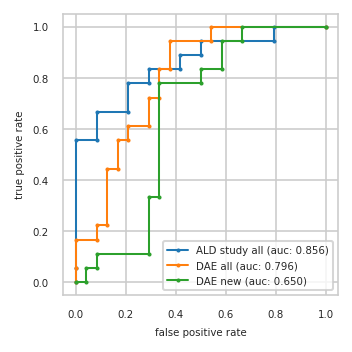

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.556   0.000 0.167   0.042 0.056
3          0.083 0.556   0.083 0.167   0.083 0.056
4          0.083 0.667   0.083 0.222   0.083 0.111
5          0.208 0.667   0.125 0.222   0.292 0.111
6          0.208 0.778   0.125 0.444   0.292 0.333
7          0.292 0.778   0.167 0.444   0.333 0.333
8          0.292 0.833   0.167 0.556   0.333 0.778
9          0.417 0.833   0.208 0.556   0.500 0.778
10         0.417 0.889   0.208 0.611   0.500 0.833
11         0.500 0.889   0.292 0.611   0.583 0.833
12         0.500 0.944   0.292 0.722   0.583 0.944
13         0.792 0.944   0.333 0.722   0.667 0.944
14         0.792 1.000   0.333 0.833   0.667 1.000
15         1.000 1.000   0.375 0.833   1.000 1.000
16           NaN   NaN   0.375 0.944     NaN   NaN
17           NaN   NaN   0.542 0.944     NaN   NaN
18           NaN   NaN   0.542 1.000     NaN   NaN
19           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P01597;P04432,P22676,H0Y7T8;P49418;P49418-2
2,P09417,Q5VWW1,Q9NUQ9
3,P61981,Q14894,P31321
4,P14174,P63104,P51688
5,P04075,Q9Y2T3;Q9Y2T3-3,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
6,P00338;P00338-3,P25189;P25189-2,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,C9JF17;P05090,P61981,Q96GD0
8,Q6EMK4,P04075,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


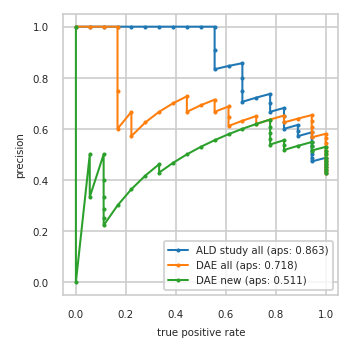

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.571 0.889     0.607 0.944     0.536 0.833
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.615 0.889     0.654 0.944     0.538 0.778
17         0.600 0.833     0.640 0.889     0.560 0.778
18         0.625 0.833     0.625 0.833     0.583 0.778
19         0.652 0.833     0.652 0.833     0.609 0.778
20         0.682 0.833     0.636 0.778     0.636 0.778
21         0.667 0.778     0.619 0.722     0.619 0.722
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.722 0.722     0.611 0.611     0.556 0.556
25         0.706 0.667     0.647 0.611     0.529 0.500
26         0.750 0.667     0.688 0.611     0.500 0.444
27         0.800 0.667     0.667 0.556     0.467 0.389
28         0.857 0.667     0.714 0.556     0.429 0.333
29         0.846 0.611     0.692 0.500     0.462 0.333
30         0.833 0.556     0.667 0.444     0.417 0.278
31         0.909 0.556     0.727 0.444     0.364 0.222
32         1.000 0.556     0.700 0.389     0.300 0.167
33         1.000 0.500     0.667 0.333     0.222 0.111
34         1.000 0.444     0.625 0.278     0.250 0.111
35         1.000 0.389     0.571 0.222     0.286 0.111
36         1.000 0.333     0.667 0.222     0.333 0.111
37         1.000 0.278     0.600 0.167     0.400 0.111
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


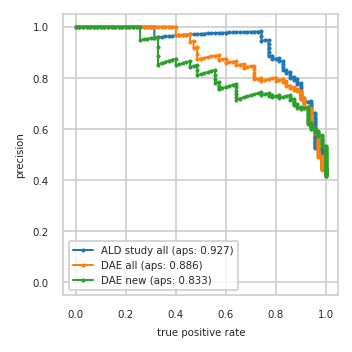

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


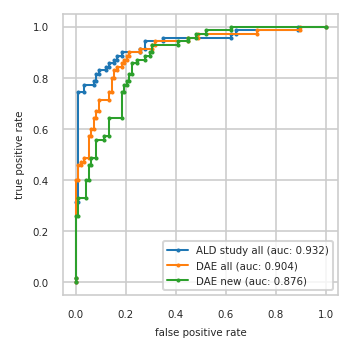

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}